# Capstone Project: Stroke Risk Prediction #
This is a capstone project for Springboard's data science intensive track. The dataset used in this project is sourced from the data science competition sponsor by McKinsey analytics and held in a platform "Analytics Vidhya". 
The competition link can be found here [contest page] (https://datahack.analyticsvidhya.com/contest/mckinsey-analytics-online-hackathon/).

**Dataset:**
The data source was contributed by a chain of hospital clients based in US for McKinsey consulting firm. McKinsey hosted this dataset as open data science hack competition on Analytics Vidhya. The dataset consists of 11 features on anonymized patients including mixed variables (i.e., numerical and categorical) such as patient ID, gender, health conditions and other demographic features. The volume of dataset contains about 43,000 patient cases.

**Goal:** 
To develop a classification model predicts patients at high risks of developing a stroke condition

**Results:**
86% of auc_roc score made on test set of patient population using Logistic Regression classifier.

**Risks:**
Model incorrectly identified with 25% of error (especially error being Type I error).

**Mitigation:**
Review identified cases with a group of clinicians before any clinical decision making

**Next Steps for Future Work:**
* Collection of meaningful features.
* Model improvement: algorithms, resampling strategies and classifier designs (i.e., age-specific)

**Recommendations for Clients:**
1. Implement additional stroke screening test at a recommended age (before 65-year-old)
2. Collect meaningful features for building an accurate model: stress level, physical activity, genetic factors, etc.
3. Conduct cohort studies: further study and stratify patient groups into diabetic and obese population based on given average glucose level and body mass index (BMI) defined by clinical study guidelines.

## Part 1 - DEFINE ##

**Problem Statement:** a chain of hospitals in US collected anonymized pool of patients data for stroke classification. Stroke is one of critical disease which affects nearly 1 in 20 Americans and is a disease that affects arteries leading to and within the brain. A stroke occurs when a blood vessel that carries oxygen and nutrients to the brain is either blocked by a clot or ruptures. When that happens part of the brain cannot get the blood (and oxygen) it needs, so the brain cells in the affected region is dead. The clients captured several lifestyle, health monitoring measurements and demographic factors about their anonymized patients. These include features like age, gender, health monitoring measurements (i.e., glucose level, body mass index) and lifestyle factors (i.e., smoking status, occupation type etc.). 

**Stakeholders:**
Hospital cardiac unit managers, a group of clinicians, insurance companies and employers from patient population.

In [1]:
# Import all libraries #
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
plt.style.use('ggplot')
import operator
from itertools import cycle
import scipy.stats as sp
from scipy import interp
from sklearn.externals import six
from sklearn.pipeline import _name_estimators
import sklearn.metrics as skm
import sklearn.base as skb
from sklearn.utils import shuffle, resample
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from sklearn.preprocessing import Imputer, StandardScaler, LabelEncoder
from sklearn.model_selection import KFold, train_test_split
from sklearn.model_selection import cross_val_predict, cross_val_score, RandomizedSearchCV
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

# Authorship:
__author__ = 'Taesun Yoo'
__email__ = 'yoots1988@gmail.com'

C:\Users\yoots\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


## Part 2 - DISCOVERY ##

In [2]:
# --- 2. Write Out List of Functions --- #
def load_file(file):
    '''load the CSV files as a dataframe'''
    df = pd.read_csv(file)
    return df

def drop_column_by_index(df, var):
    '''drop a column by specified variable'''
    df = df.drop(var, axis=1)
    return df

def join_data(df_train, df_label, key, 
              left_index=None, right_index=None):
    '''Merge the feature and label dataframe(s)'''
    df_join = pd.merge(df_train, df_label, how='inner', on=key,
                         left_index=False, right_index=False)
    return df_join

def clean_data(df):
    '''drop any duplicate based on specific column'''
    clean_df = df.drop_duplicates(subset='id')
    return clean_df

def eda_missing_data(df):
    missing_df = pd.DataFrame(df.isnull().sum())
    missing_df.columns = ['count']
    missing_df['pct'] = (missing_df['count']/len(df))*100
    return missing_df

def eda_summary_stat_num(df):
    '''compute summary statistics for numerical variables'''
    df_stat_num = df.describe().T
    df_stat_num = df_stat_num[['count', 'min', 'mean', 'max', '25%', '50%', '75%', 'std']]
    df_stat_num = df_stat_num.sort_values(by='count', ascending=True)
    df_stat_num = pd.DataFrame(df_stat_num)
    return df_stat_num

def eda_summary_stat_cat(df):
    '''compute summary statistics for categorical variables'''
    df_stat_cat = pd.DataFrame(df.describe(include='O').T)
    return df_stat_cat

def compute_outliers(df_stat_num):
    df_stat_num['IQR'] = df_stat_num['75%'] - df_stat_num['25%']
    df_stat_num['UB'] = df_stat_num['75%'] + 1.5*df_stat_num['IQR']
    df_stat_num['LB'] = df_stat_num['25%'] - 1.5*df_stat_num['IQR']
    df_outliers = df_stat_num[['LB', 'min', 'UB', 'max']]
    return df_outliers

def EDA_plot_correlation(df_EDA):
    '''compute and plot correlation matrix'''
    corr = df_EDA.corr()
    # Create a mask to filter matrix: diagonally
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    # Matrix Plot:
    fig, ax = plt.subplots(figsize=(7,7))
    cmap = sns.diverging_palette(220,10,as_cmap=True)
    sns.set(font_scale=1.1)
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                annot=True, square=True, linewidths=.5, fmt=".2f",
                annot_kws={'size':10}, cbar_kws={'shrink':.6})
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)

def encode_categorical_feature(df, var_name, map_name):
    '''encode categorical features into mapping values'''
    df[var_name] = df[var_name].map(map_name)
    return df[var_name]

def feature_imputer(X, missing_val_format, method, indices):
    '''imputes missing values based on different uni-variate methods'''
    imputer = Imputer(missing_values=missing_val_format, strategy=method, axis=0)
    imputer = imputer.fit(X.iloc[:, indices])
    X.iloc[:, indices] = imputer.transform(X.iloc[:, indices])
    return X.iloc[:, indices]

def convert_data_type(df, var_name, dt_type):
    '''convert data type into specified metadata type'''
    df[var_name] = df[var_name].astype(dt_type)
    return df[var_name]

def split_dataframe(df):
    '''Split dataframe into features and label'''
    X, y = df.iloc[:, :-1], df.iloc[:, -1]
    return X, y

def avg_groupby_data(df, num_var, cat_var, avg_var_name):
    '''perform average group by categorical variable to compute a mean'''
    avg_groupby_val = df.groupby(cat_var)[num_var].mean().sort_values(ascending=False)
    avg_groupby_df = pd.DataFrame({cat_var:list(df[cat_var].unique()),
                                   avg_var_name:avg_groupby_val})
    avg_groupby_df.reset_index(drop=True, inplace=True)
    return avg_groupby_df

def left_join_data(train_df, avg_groupby_df, key=None, left_index=False, right_index=False):
    '''performs left join on train data to average groupby data'''
    joined_df = pd.merge(train_df, avg_groupby_df, how='left', on=key,
                         left_index=left_index, right_index=right_index)
    return joined_df

def one_hot_encode_feature(df, cat_vars=None, num_vars=None):
    '''performs one-hot encoding on all categorical variables and
       combine results with numerical variables '''
    cat_df = pd.get_dummies(df[cat_vars], drop_first=True)
    num_df = df[num_vars].apply(pd.to_numeric)
    return pd.concat([cat_df, num_df], axis=1)

def get_label_data(df, label_var):
    '''separate label from a dataframe'''
    df_label = df[label_var]
    return df_label

def split_data_by_age_group(df, var_name):
    '''split dataframe by age group'''
    df_age_group = pd.DataFrame(df.groupby(var_name)[var_name].count().sort_values(ascending=False))
    df_age_group.columns = ['count']
    df_age_group.index.name = 'age_group'
    return df_age_group

def strata_by_age_group(df, group_name, idx):
    '''stratify dataframe by label group index'''
    df_strata = df[df[group_name] == idx]
    return df_strata

def resample_data_by_group(df, n_samples):
    '''resample data by random replacement'''
    sample_group = resample(df, n_samples=n_samples, random_state=0, replace=True)
    return sample_group

def EDA_feature_importance_plot(model, X, y):
    '''plots the feature importance plot on trained model'''
    model = model
    model.fit(X, y)
    feat_labels = X.columns
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    plt.bar(range(X.shape[1]), importances[indices], align='center')
    plt.xticks(range(X.shape[1]), feat_labels[indices], rotation=90, fontsize=7)
    plt.xlim(-1, X.shape[1])

def feature_scale_data(X):
    '''Feature scaled data based on standardization'''
    sc_X = StandardScaler()
    X_std = sc_X.fit_transform(X)
    return X_std
    
# Plot confusion matrix: accuracy, precision, recall and etc.
def plot_confusion_matrix(cm, classes):
    '''plot the confusion matrix of trained model'''
    fig, ax = plt.subplots(figsize=(7,7))
    cm = cm.astype('float')/cm.sum()
    
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt='.2f'
    thresh = cm.max()/2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i,j], fmt), ha='center', va='center',
                    color='white' if cm[i,j] > thresh else 'black')
    plt.xlabel('predicted label')
    plt.ylabel('true label')

# Write report classification metrics summary report
def report_class_summary(model_name, y_act, y_pred):
    print ('Accuracy of ' + model_name + ' is %0.2f'% skm.accuracy_score(y_act, y_pred))
    print ('Precision of ' + model_name + ' is %0.2f'% skm.precision_score(y_act, y_pred))
    print ('Recall of ' + model_name + ' is %0.2f'% skm.recall_score(y_act, y_pred))
    print ('ROC score of ' + model_name + ' is %0.2f'% skm.roc_auc_score(y_act, y_pred))

# Compute confusion matrix:
def compute_confusion_matrix(y_act, y_pred):
    '''compute sklearn confusion matrix'''
    cm_model = skm.confusion_matrix(y_act, y_pred)
    return cm_model    

def score_model_roc_auc(model, X_train, y_train, X_val, y_val):
    '''computes the roc_auc score for probability of being a stroke case'''
    model.fit(X_train, y_train)
    probs = model.predict_proba(X_val)
    return skm.roc_auc_score(y_val, probs[:,1])

def model_tuning_param(model, feature_df, label_df, param_dist, n_iter):
    '''performs RandomizedSearchCV to tune model hyper-parameters'''
    random_search = RandomizedSearchCV(model, param_dist, n_iter, cv=5)
    random_search.fit(feature_df, label_df)
    return random_search

def print_best_param(random_search, param_1=None, param_2=None, param_3=None, param_4=None):
    '''print the best model parameter(s)'''
    print("Best " + param_1 + ":", random_search.best_estimator_.get_params()[param_1])
    print("Best " + param_2 + ":", random_search.best_estimator_.get_params()[param_2])
    print("Best " + param_3 + ":", random_search.best_estimator_.get_params()[param_3])
    print("Best " + param_4 + ":", random_search.best_estimator_.get_params()[param_4])

def model_train(model, feature_df, label_df, n_proc, mean_roc_auc, cv_std):
    '''train a model and output mean roc_auc and CV std.dev roc_auc'''
    roc_auc = cross_val_score(model, feature_df, label_df, n_jobs=n_proc,
                               cv=5, scoring='roc_auc')
    mean_roc_auc[model] = np.mean(roc_auc)
    cv_std[model] = np.std(roc_auc)    

def model_summary(model, mean_roc_auc, cv_std):
    '''print out the model performances'''
    print('\nModel:\n', model)
    print('Average roc_auc:\n', mean_roc_auc[model])
    print('Std. Dev during CV:\n', cv_std[model])    

def model_results(model, mean_roc_auc, predictions, feature_importances):
    '''saves the model name, mean_roc_auc, predicted rate, and feature importances'''
    with open('model.txt', 'w') as file:
        file.write(str(model))
        feature_importances.to_csv('feat_importances.csv')
        predictions.to_csv('pred_results_best.csv', index=False)

In [3]:
# --- 3. Load the data --- #
if __name__ == '__main__':
# Define input CSVs:
    train_file = 'stroke_train.csv'
    test_file = 'stroke_test.csv'

# Define type of variables list:
#df_train.select_dtypes(include='object').columns
cat_vars = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

#df_train.select_dtypes(include='int64').columns
#df_train.select_dtypes(include='float64').columns
num_vars = ['hypertension', 'heart_disease', 'age', 'avg_glucose_level', 'bmi']
label_var = 'stroke'

# Define variables to drop
list_vars = 'id'

# Load data
df_train = load_file(train_file)
df_test = load_file(test_file)

# Check the metadata of dataframe:
df_train.info()

# Create a label dataframe:
df_label = df_train[['id', 'stroke']]

# Drop a column by index: poverty_rate
df_train = drop_column_by_index(df_train, label_var)

# join train set and label:
train_raw_df = join_data(df_train, df_label, key='id')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43400 entries, 0 to 43399
Data columns (total 12 columns):
id                   43400 non-null int64
gender               43400 non-null object
age                  43400 non-null float64
hypertension         43400 non-null int64
heart_disease        43400 non-null int64
ever_married         43400 non-null object
work_type            43400 non-null object
Residence_type       43400 non-null object
avg_glucose_level    43400 non-null float64
bmi                  41938 non-null float64
smoking_status       30108 non-null object
stroke               43400 non-null int64
dtypes: float64(3), int64(4), object(5)
memory usage: 4.0+ MB


In [4]:
# --- 4. Perform data cleaning and quality check --- #
# Clean invalid data and duplicates: train and test set
clean_train_df = shuffle(clean_data(train_raw_df)).reset_index(drop=True)
clean_test_df = shuffle(clean_data(df_test)).reset_index(drop=True)

del (train_raw_df, df_test)

clean_train_df = drop_column_by_index(clean_train_df, list_vars)

# Compute missing value % on a dataframe:
missing_df_train = eda_missing_data(clean_train_df)
missing_df_test = eda_missing_data(clean_test_df)

In [5]:
missing_df_train

,count,pct
gender,0,0.000000
age,0,0.000000
hypertension,0,0.000000
heart_disease,0,0.000000
ever_married,0,0.000000
work_type,0,0.000000
Residence_type,0,0.000000
avg_glucose_level,0,0.000000
bmi,1462,3.368664
smoking_status,13292,30.626728


### Check # of missing value counts and percentage ###

* Smoking_status is a categorical feature and about 30.6% of observations are missing.
* Followed by BMI is a numerical feature and about 3.37% of observations are missing.

### Compute Summary Statistics: pre-data cleansing ###
Compute summary statistics and report on numerical features only!

In [6]:
# --- 5. Explore the data (EDA) --- # 
# Compute summary statistics
df_stat_num = eda_summary_stat_num(clean_train_df[num_vars])
df_stat_cat = eda_summary_stat_cat(clean_train_df)

# save row_id from test set:
df_test_id = clean_test_df['id']
clean_test_df = drop_column_by_index(clean_test_df, list_vars)

In [7]:
df_stat_num

,count,min,mean,max,25%,50%,75%,std
bmi,41938.0,10.10,28.605038,97.60,23.20,27.70,32.90,7.770020
hypertension,43400.0,0.00,0.093571,1.00,0.00,0.00,0.00,0.291235
heart_disease,43400.0,0.00,0.047512,1.00,0.00,0.00,0.00,0.212733
age,43400.0,0.08,42.217894,82.00,24.00,44.00,60.00,22.519649
avg_glucose_level,43400.0,55.00,104.482750,291.05,77.54,91.58,112.07,43.111751


In [8]:
df_stat_cat

,count,unique,top,freq
gender,43400,3,Female,25665
ever_married,43400,2,Yes,27938
work_type,43400,5,Private,24834
Residence_type,43400,2,Urban,21756
smoking_status,30108,3,never smoked,16053


### Handling outliers with inter-quartile range (IQR) method ###
Outliers were required to be managed properly on numerical features. In a training set, there were three independent features (i.e., continuous). These included “age”, “BMI” and “avg_glucose_level”. Interquartile range (IQR) method applied here. For example, if any value of a feature sits below lower and above upper bounds of IQR, these observations will be removed from dataset. 

IQR is defined as: IQR = Q3 – Q1 in which Q3 is 75th percentile and Q1 is 25th percentile of a feature. Lower bound (LB) equals to Q1 – (1.5*IQR) and upper bound (UB) equals to Q3 + (1.5*IQR).

From above definition, summary table was computed on all three numerical features. We can observed that the max. value on each of feature is greater than the upper bound value for average glucose and BMI. Therefore, presence of outliers were confirmed for BMI and average glucose level on beyond upper bound values.

In [9]:
# Check 3: handling outliers using IQR #
###############################################################################
# Compute IQR, LB, UB:        
df_outliers = compute_outliers(df_stat_num)
df_outliers

,LB,min,UB,max
bmi,8.650,10.10,47.450,97.60
hypertension,0.000,0.00,0.000,1.00
heart_disease,0.000,0.00,0.000,1.00
age,-30.000,0.08,114.000,82.00
avg_glucose_level,25.745,55.00,163.865,291.05


There were outliers on BMI and avg_glucose_level since max. value of these features are greater than their defined UB values.

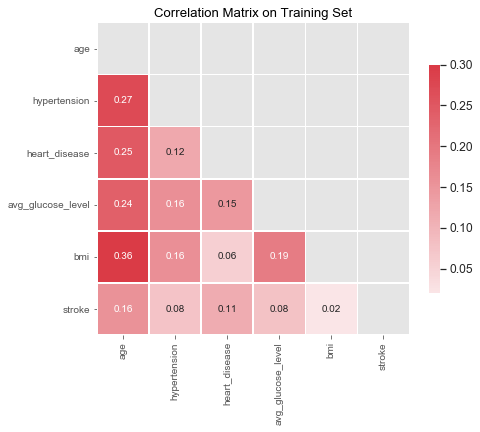

stroke               1.000000
age                  0.156049
heart_disease        0.113763
avg_glucose_level    0.078917
hypertension         0.075332
bmi                  0.020285
Name: stroke, dtype: float64


In [10]:
# Correlation matrix plot # 
###########################
df_EDA = clean_train_df.copy()
df_EDA = drop_column_by_index(df_EDA, cat_vars)

# Plot correlation matrix
EDA_plot_correlation(df_EDA)
plt.title('Correlation Matrix on Training Set')
plt.show()

# Compute the correlation of each feature against poverty rate: order of magnitude
CM_summary = df_EDA.corr().sort_values(by=['stroke'], ascending=False)['stroke']
print(CM_summary)

### Feature Encoding ###
Feature encoding is a process where features are encoded into right format. There are two types of feature encoding: ordinal and nominal feature encoding. Ordinal feature encoding is a type of encoding where feature actually contains information about "order" like increase or decrease in value (i.e., score level, date, etc). Whereas nominal feature encoding is a type of encoding where feature contains a class of label like gender (i.e., male or female). 

**Ordinal feature encoding:** smoking_status. 
Smoking status is a feature where it has an order of smoking level progresses from never smoked to frequent smoker.
Thus, smoking status gets mapped into numerical values then gets printed after ordinal feature encoding for checking data consistency.

**Nominal feature encoding:** hypertension and heart_disease.
These two feature(s) have meaning of different class labels being "Yes" or "No" but already pre-encoded as numerical value(s) being "1" or "0". The main reason why these features are re-encoded back into word string is for exploratory data analysis phase. It is best practice to keep data format consistent among same type of variable or feature like "ever_married" which is originally contained value as a string "Yes" or "No".

In [11]:
# --- 6. Feature encode on categorical variables --- #
# Mapping ordinal and nominal features to integer:
smoking_status_map = {'never smoked':0, 'formerly smoked':1, 'smokes':2}
hypertension_map = {0:'No', 1:'Yes'}    
heart_disease_map = {0:'No', 1:'Yes'}

# Encode features into to mapping values: train set
clean_train_df['smoking_status'] = encode_categorical_feature(clean_train_df, 'smoking_status', smoking_status_map)
clean_train_df['hypertension'] = encode_categorical_feature(clean_train_df, 'hypertension', hypertension_map)
clean_train_df['heart_disease'] = encode_categorical_feature(clean_train_df, 'heart_disease', heart_disease_map)

# Encode features into to mapping values: test set
clean_test_df['smoking_status'] = encode_categorical_feature(clean_test_df, 'smoking_status', smoking_status_map)
clean_test_df['hypertension'] = encode_categorical_feature(clean_test_df, 'hypertension', hypertension_map)
clean_test_df['heart_disease'] = encode_categorical_feature(clean_test_df, 'heart_disease', heart_disease_map)

clean_train_df.isnull().sum()
clean_test_df.isnull().sum()

gender                  0
age                     0
hypertension            0
heart_disease           0
ever_married            0
work_type               0
Residence_type          0
avg_glucose_level       0
bmi                   591
smoking_status       5751
dtype: int64

### Feature Imputation ###

Let's compute feature imputation to replace missing values by following:
Mode: smoking_status
Mean: bmi (idx: 8, 9)
Note: how different types of features were treated by different univariate methods for missing value replacement.

First, 'smoking_status' was an ordinal (categorical) feature. Thus, it makes sense to replace missing values by most frequently occurred value (mode).
Second, 'bmi' was a numerical feature. Also the feature showed normal distributions upon plotting a histogram. Thus, this can be replaced by mean.

In [12]:
# --- 7. Feature imputation via univariate techniques --- #    
# Split data into input features and target variable #
X_train, y_train = split_dataframe(clean_train_df)
X_test = clean_test_df.copy()

del(clean_train_df, clean_test_df)

# check input features and target variable: train and test sets
print(X_train.head(), y_train.head())

# Imputation by mode, mean and median: train and test sets
indices_1 = range(8,9)
indices_2 = range(9,10)

# impute bmi and smoking_status by univariate methods: train and test sets
X_train.iloc[:, indices_1] = feature_imputer(X_train, 'NaN', 'median', indices_1)
X_train.iloc[:, indices_2] = feature_imputer(X_train, 'NaN', 'most_frequent', indices_2)

X_test.iloc[:, indices_1] = feature_imputer(X_test, 'NaN', 'median', indices_1)
X_test.iloc[:, indices_2] = feature_imputer(X_test, 'NaN', 'most_frequent', indices_2)

# concatenated imputed inputs and output label:
imputed_train_df = pd.concat([X_train, y_train], axis=1)
imputed_test_df = X_test.copy()

del(X_train, y_train, X_test)

# convert smoking_status back to original string:
inv_smoking_status_map = {key:value for value, key in smoking_status_map.items()}
imputed_train_df['smoking_status'] = encode_categorical_feature(imputed_train_df, 'smoking_status', inv_smoking_status_map)
imputed_test_df['smoking_status'] = encode_categorical_feature(imputed_test_df, 'smoking_status', inv_smoking_status_map)

# check any missing values on imputed df:
imputed_train_df.isnull().sum()
imputed_test_df.isnull().sum()

# check cleaned dataframe: data types
imputed_train_df.dtypes
imputed_test_df.dtypes

# Save feature_df for EDA portfolio:
imputed_train_df.head()
df_eda_stroke = imputed_train_df.copy()
df_eda_stroke.to_csv('df_eda_stroke.csv', index=False)

   gender   age hypertension heart_disease ever_married work_type  \
0    Male  61.0           No            No          Yes  Govt_job   
1  Female   3.0           No            No           No  children   
2  Female  43.0           No            No          Yes   Private   
3    Male  13.0           No            No           No   Private   
4    Male  46.0          Yes            No          Yes   Private   

  Residence_type  avg_glucose_level   bmi  smoking_status  
0          Rural              57.19  23.8             0.0  
1          Urban             144.02  16.0             NaN  
2          Rural             200.06  28.6             1.0  
3          Rural              99.44  21.0             0.0  
4          Rural              65.68  36.7             0.0   0    0
1    0
2    0
3    0
4    0
Name: stroke, dtype: int64


C:\Users\yoots\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\yoots\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\yoots\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\yoots\AppData\Local\Continuum\anaconda3\

### Feature Engineering ###
Using a groupby function and computing a mean to create a set of new feature(s) from existing feature(s).

In [13]:
# --- 8. Feature engineering: groupby categorical var ---
# Skipped for now #

# convert data types for correct metadata: train and test sets
imputed_train_df['gender'] = convert_data_type(imputed_train_df, 'gender', 'category')
imputed_train_df['hypertension'] = convert_data_type(imputed_train_df, 'hypertension', 'category')
imputed_train_df['heart_disease'] = convert_data_type(imputed_train_df, 'heart_disease', 'category')
imputed_train_df['ever_married'] = convert_data_type(imputed_train_df, 'ever_married', 'category')
imputed_train_df['work_type'] = convert_data_type(imputed_train_df, 'work_type', 'category')
imputed_train_df['Residence_type'] = convert_data_type(imputed_train_df, 'Residence_type', 'category')
imputed_train_df['smoking_status'] = convert_data_type(imputed_train_df, 'smoking_status', 'category')

### One-Hot Encoding: Dummy Variables ###
One-Hot-Encoding on nominal feature allows to create a separate column on each feature and its value are only encoded "0" or "1". This dummy indicator gets interpreted the ML models for making accurate predictions.

Also to reduce any potential biases of having multi-colinearity, each feature's first encoded dummy variable must be dropped to avoid dummy variable trap (i.e., where independent variables are highly inter-correlated with each other as one predictor can be predicted from other of similar variables: gender_female vs. gender_male vs. gender_other).

In [14]:
# --- 9. One-hot-encode on features --- # 
# Drop first dummy variable to avoid dummy variable trap on each converted feature!
num_vars2 = list(imputed_train_df.select_dtypes(include='float64').columns)
cat_vars2 = list(imputed_train_df.select_dtypes(include='category').columns)

feature_df = one_hot_encode_feature(imputed_train_df, cat_vars=cat_vars2, num_vars=num_vars2)
test_df = one_hot_encode_feature(imputed_test_df, cat_vars=cat_vars2, num_vars=num_vars2)

# List total number of encoded inputs and output:
feature_df.isnull().sum()
test_df.isnull().sum()

# Compute label: stroke
label_df = get_label_data(imputed_train_df, label_var)
del(imputed_train_df, imputed_test_df)

### SMOTE: Re-Sampling ###
A given stroke patient dataset is highly imbalanced where majority of cases were non-stroke (98%) and only 2% (stroke). This is the most common problem for the classifier model which will likely to predict as a non-stroke patient in many cases.

Thus, resampling technique was applied to resolve this imbalanced classes posed on this dataset. SMOTE is one of the most common algorithm(s) that are used heavily to resolve this problem. The algorithm can perform over-sampling or down-sampling to increase or decrease the sample size on a specified label (i.e., non-stroke:0, stroke:1). 

In this case, the over-sampling was performed on the minority class label (i.e., stroke cases) to increase the available sample size for model training.

1    38355
0    38355
dtype: int64

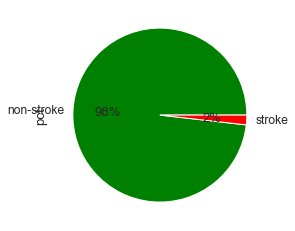

In [15]:
# --- 10. Compute Proportion (%) of Stroke --- # 
df_feature_train = pd.concat([feature_df, label_df], axis=1)
df_stroke_pct = pd.DataFrame(df_feature_train.groupby('stroke')['age'].count())
df_stroke_pct.columns=['count']
df_stroke_pct['pct'] = (df_stroke_pct['count']/len(df_feature_train))*100

df_stroke_pct['pct'].plot(kind='pie', labels=['non-stroke','stroke'],
                         colors=['green','red'], autopct='%1.0f%%')

# --- 11. Resampling on non-stroke patients by non-stroke patients proportion --- # 
# --- SMOTE: oversample on minority class label --- #
X_train, X_val, y_train, y_val = train_test_split(feature_df, label_df, test_size=.1,
                                                    random_state=0, stratify=label_df)

sm = SMOTE(random_state=0, ratio='minority', n_jobs=-1)
X_train_resampled, y_train_resampled = sm.fit_sample(X_train, y_train)

pd.value_counts(y_train_resampled)

In [16]:
# --- 12. Feature seleciton: Feature Importance --- # 

In [17]:
# --- 13. Establish a baseline model --- # 
baseline = RandomForestClassifier(n_estimators=100, n_jobs=-1)
baseline.fit(X_train_resampled, y_train_resampled)

probs = baseline.predict_proba(X_val)
predictions = baseline.predict(X_val)

skm.roc_auc_score(y_val, probs[:,1]) # probabilities on 'stroke' cases only

test_probs = baseline.predict_proba(test_df)
results = pd.DataFrame({'id':df_test_id,
                        'stroke':test_probs[:,1]})
results.to_csv('prob_results_baseline.csv', index=False, index_label=None)

## Part 3 - DEVELOP ##

In [18]:
# --- 14. Create models --- # 
# initialize model list and dicts
models = []
mean_roc_auc = {}
cv_std = {}
res = {}

# define common model parameters: num processors and shared model parameters
n_proc = 1
verbose_lv = 5

# create and tune the models that you brainstormed during part 2
###############################################################################        
# Hyper-parameters tuning: LogisticRegression
lr = LogisticRegression()
n_iter = 10
param_dist_lr = dict(tol=np.random.uniform(0, 0.0001, 10), C=sp.randint(1,50),
                     penalty=['l1', 'l2'], solver=['liblinear','saga'])
random_search_lr = model_tuning_param(lr, X_train_resampled, y_train_resampled, param_dist_lr, n_iter)

# print the best model parameters: LogisticRegression    
param_1 = 'tol'
param_2 = 'C'
param_3 = 'penalty'
param_4 = 'solver'

print_best_param(random_search_lr, param_1, param_2, param_3, param_4)
###############################################################################        
# Hyper-parameters tuning: DecisionTree
tree = DecisionTreeClassifier(criterion='gini', random_state=0)

n_iter = 10
param_dist_tree = {'max_depth': sp.randint(10,100),
                 'min_samples_split': sp.randint(2,10),
                 'min_samples_leaf': sp.randint(2,10),
                 'max_features': sp.randint(2,10)}

random_search_tree = model_tuning_param(tree, X_train_resampled, y_train_resampled, param_dist_tree, n_iter)

# print the best model parameters: LogisticRegression    
param_1 = 'max_depth'
param_2 = 'min_samples_split'
param_3 = 'min_samples_leaf'
param_4 = 'max_features'

print_best_param(random_search_tree, param_1, param_2, param_3, param_4)
###############################################################################        
# Hyper-parameters tuning: RandomForest
forest = RandomForestClassifier(criterion='gini', random_state=0)

n_iter = 10
param_dist_forest = {'n_estimators': sp.randint(10,100),
                     'max_depth': sp.randint(10,100),
                     'min_samples_split': sp.randint(2,10),
                     'min_samples_leaf': sp.randint(2,10)}

random_search_forest = model_tuning_param(forest, X_train_resampled, y_train_resampled, param_dist_forest, n_iter)

# print the best model parameters: LogisticRegression    
param_1 = 'n_estimators'
param_2 = 'max_depth'
param_3 = 'min_samples_split'
param_4 = 'min_samples_leaf'

print_best_param(random_search_forest, param_1, param_2, param_3, param_4)
###############################################################################    
# Hyper-parameters tuning: XGBoost
xgb = XGBClassifier(random_state=0)
n_iter = 10

param_dist_xgb = {'n_estimators': sp.randint(10,100),
                 'max_depth': sp.randint(10,100),
                 'colsample_bytree': np.random.uniform(0, 1, 10),
                 'learning_rate': np.random.uniform(0, 1, 10)}

random_search_xgb = model_tuning_param(xgb, X_train_resampled, y_train_resampled, param_dist_xgb, n_iter)

# print the best model parameters: LogisticRegression    
param_1 = 'n_estimators'
param_2 = 'max_depth'
param_3 = 'colsample_bytree'
param_4 = 'learning_rate'

print_best_param(random_search_xgb, param_1, param_2, param_3, param_4)
###############################################################################

C:\Users\yoots\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\yoots\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\yoots\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\yoots\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\yoots\AppData\Local\Continuum\anaconda3\lib\sit

Best tol: 2.530180963314126e-05
Best C: 17
Best penalty: l1
Best solver: liblinear
Best max_depth: 56
Best min_samples_split: 2
Best min_samples_leaf: 4
Best max_features: 9
Best n_estimators: 36
Best max_depth: 78
Best min_samples_split: 8
Best min_samples_leaf: 2
Best n_estimators: 97
Best max_depth: 72
Best colsample_bytree: 0.622972129608751
Best learning_rate: 0.2622664165389321


In [19]:
# --- 15. Cross-validate models --- # 
# 5-fold cross validation on models and measure MSE
# Model List to train: Order of Model Complexity
lr = LogisticRegression(tol=9.70e-05, C=23, penalty='l1', solver='liblinear')
tree = DecisionTreeClassifier(max_depth=22, min_samples_split=4, min_samples_leaf=4,
                              max_features=9, random_state=0)
forest = RandomForestClassifier(n_estimators=57, max_depth=57, min_samples_split=2,
                                min_samples_leaf=2, random_state=0) 
xgb = XGBClassifier(n_estimators=10, max_depth=27, colsample_bytree=0.6961848271007864,
                    learning_rate=0.6688016439095642, random_state=0)
# List of classifiers:
models.extend([lr, tree, forest, xgb])

# cross-validate models, using roc_auc to evaluate and print the summaries
print('begin cross-validation')
for model in models:
    model_train(model, X_train_resampled, y_train_resampled, n_proc, mean_roc_auc, cv_std)
    model_summary(model, mean_roc_auc, cv_std)

# --- 16. Select the best model with lowest RMSE for your prediction model --- #
model = max(mean_roc_auc, key=mean_roc_auc.get)
print('\nBest model with the highest mean roc_auc:')
print(model)

begin cross-validation

Model:
 LogisticRegression(C=23, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=9.7e-05,
                   verbose=0, warm_start=False)
Average roc_auc:
 0.8599248378443696
Std. Dev during CV:
 0.0018856274652545046

Model:
 DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=22,
                       max_features=9, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=4,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=0, splitter='best')
Average roc_auc:
 0.9891155261905749
Std. Dev during CV:
 0.015868393789200495

Model:
 RandomForestClassifier(bootstrap=True, class_weight=None, criter

### Model Evaluation: using Feature Selection ###
Compute a roc_auc score on "stroke cases" for following models:
* Logistic Regression
* Decision Tree Classifier
* Random Forest Classifier
* XGBoost Classifier

In [20]:
# --- 17. Compute roc_auc score on "stroke cases only!" --- #
###############################################################################
score_model_roc_auc(xgb, X_train_resampled,
                    y_train_resampled, X_val.values, y_val)

score_model_roc_auc(tree, X_train_resampled,
                    y_train_resampled, X_val, y_val)

score_model_roc_auc(forest, X_train_resampled,
                    y_train_resampled, X_val, y_val)

score_model_roc_auc(lr, X_train_resampled,
                    y_train_resampled, X_val, y_val)

0.8561557713364376

### Model 1: Logistic Regression ###
Logistic regression works by using a logit function to transform input value of features and calculate estimated probabilities of a label in range of [0,1]. For example, if P(1=stroke) ≥ 0.5, an observation is predicted as a stroke. Whereas if P(1=stroke) < 0.5, an observation is predicted as a non-stroke.

### Model 2: Decision Tree ###
Decision tree is an algorithm where it predicts the value of a target variable (label) by learning simple decision rules inferred from selected features. Tree is generated and split data on features. It continues to split in repetitive process at each node until leaves reached purity (i.e., remaining samples at each node belongs to same class either non-stroke or stroke cases only).

### Model 3: Random Forest ###
Random forest is a typical ensemble learning model. It takes random subsample of data from each tree, so all constructed trees are different from each other. Thus, model makes classification based on predictions made from each tree with averaging (i.e., like picking a vote from majority).

### Model 4: XGBoost ###
XGBoost is a type of gradient boosting model in which subsequent model learns from the mistakes (i.e., residual errors) of previous model in a step-wise forward manner. In Gradient Boosting, residual errors are identified gradients. These gradients help how XGBoost to improve model performances.

## Model Evaluation: Confusion Matrix ##
A confusion matrix is a table that is often used to describe the performance of a classification model (or "classifier") on a set of test data for which the true values are known.
1. True Positives (TP): These are cases in which model predicted yes (they have the disease), and they do have the disease.
2. True Negatives (TN): Model predicted no, and they don't have the disease.
3. False Positives (FP): Model predicted yes, but they don't actually have the disease. (Also known as a "Type I error.")
4. False Negatives (FN): Model predicted no, but they actually do have the disease. (Also known as a "Type II error.")

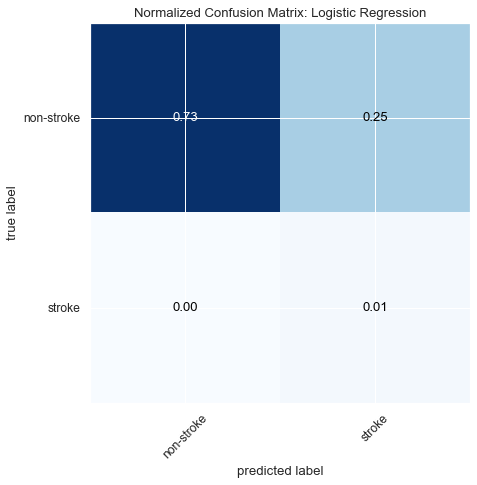

Accuracy of Logistic Regression is 0.74
Precision of Logistic Regression is 0.06
Recall of Logistic Regression is 0.82
ROC score of Logistic Regression is 0.78


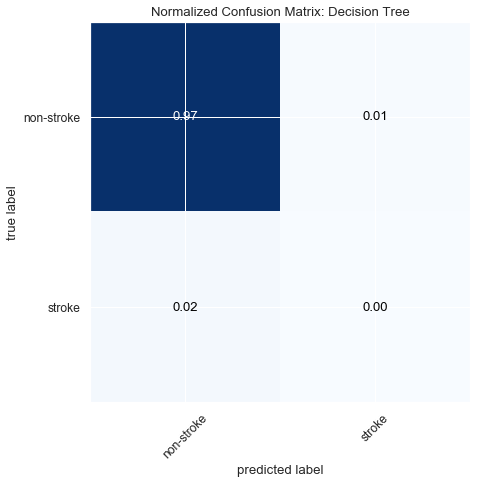

Accuracy of Decision Tree is 0.97
Precision of Decision Tree is 0.08
Recall of Decision Tree is 0.04
ROC score of Decision Tree is 0.52


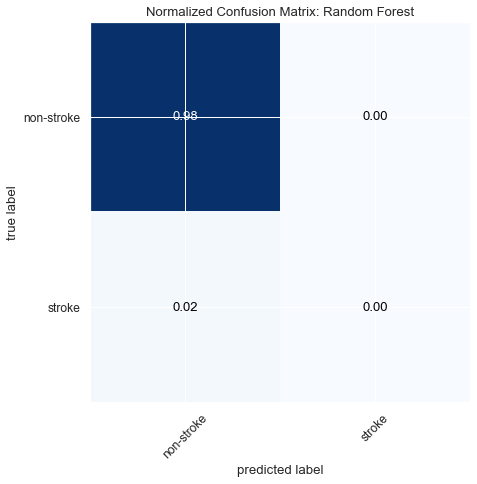

Accuracy of Random Forest is 0.98
Precision of Random Forest is 0.00
Recall of Random Forest is 0.00
ROC score of Random Forest is 0.50


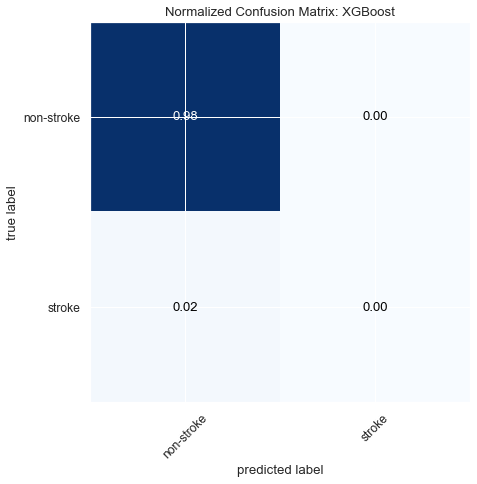

Accuracy of XGBoost is 0.98
Precision of XGBoost is 0.00
Recall of XGBoost is 0.00
ROC score of XGBoost is 0.50


In [21]:
# --- 18. Model Evaluation: Confusion Matrix, Classification Metrics ---    
# Save cross-validated predictions:
lr.fit(X_train_resampled, y_train_resampled)
y_pred_lr = lr.predict(X_val)

tree.fit(X_train_resampled, y_train_resampled)
y_pred_tree = tree.predict(X_val)

forest.fit(X_train_resampled, y_train_resampled)
y_pred_forest = forest.predict(X_val)

xgb.fit(X_train_resampled, y_train_resampled)
y_pred_xgb = xgb.predict(X_val.values)

# Compute a series of confusion matrix by model:
cm_lr = compute_confusion_matrix(y_val, y_pred_lr)

cm_tree = compute_confusion_matrix(y_val, y_pred_tree)

cm_forest = compute_confusion_matrix(y_val, y_pred_forest)

cm_xgb = compute_confusion_matrix(y_val, y_pred_xgb)

# Define class labels for stroke:
class_labels = np.array(['non-stroke', 'stroke'], dtype=str)

#####################################################
# Confusion Matrix & Classification Metrics Summary #
#####################################################
# --- Logistic Regression ---#
# Plot a confusion matrix: 
plot_confusion_matrix(cm_lr, class_labels)
plt.title('Normalized Confusion Matrix: Logistic Regression')
plt.show()

# Report classification metrics summary:
report_class_summary('Logistic Regression', y_val, y_pred_lr)

# --- Decision Tree ---#
# Plot a confusion matrix: 
plot_confusion_matrix(cm_tree, class_labels)
plt.title('Normalized Confusion Matrix: Decision Tree')
plt.show()

# Report classification metrics summary:
report_class_summary('Decision Tree', y_val, y_pred_tree)

# --- Random Forest ---#
# Plot a confusion matrix: 
plot_confusion_matrix(cm_forest, class_labels)
plt.title('Normalized Confusion Matrix: Random Forest')
plt.show()

# Report classification metrics summary:
report_class_summary('Random Forest', y_val, y_pred_forest)

# --- XGBoost Classifier ---#
# Plot a confusion matrix: 
plot_confusion_matrix(cm_xgb, class_labels)
plt.title('Normalized Confusion Matrix: XGBoost')
plt.show()

# Report classification metrics summary:
report_class_summary('XGBoost', y_val, y_pred_xgb)

In [22]:
# --- 19. Model Evaluation: ROC-AUC Curve, Precision-Recall Curve --- 
clf_labels = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'XGBoost']
all_clf = [lr, tree, forest, xgb]

## Model Evaluation: ROC curve ##
ROC curve typically displays true positive rate on the Y-axis, and false positive rate on the X-axis. This means that the top left corner of the plot is the “ideal” point - a false positive rate of zero, and a true positive rate of one. This is not very realistic, but it does mean that a larger area under the curve (AUC) is usually better. The “steepness” of ROC curves is also important, since it is ideal to maximize the true positive rate while minimizing the false positive rate.

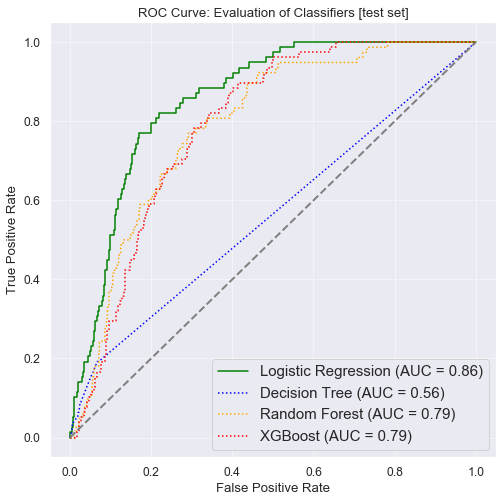

In [23]:
# plot a ROC-AUC curve
plt.figure(figsize=(8,8))
# ROC for each classifiers
colors = ['green', 'blue', 'orange', 'red']
linestyles = ['-', ':', ':', ':'] 
for clf, label, clr, ls \
    in zip(all_clf, clf_labels, colors, linestyles):  
        # Assume the label of the positive class is 1
        y_pred = clf.fit(X_train_resampled,
                         y_train_resampled).predict_proba(X_val.values)[:,1]
        fpr, tpr, thresholds = skm.roc_curve(y_true=y_val, y_score=y_pred)
        roc_auc = skm.auc(x=fpr, y=tpr)
        plt.plot(fpr, tpr, color=clr, linestyle=ls,
                 label='%s (AUC = %0.2f)' % (label, roc_auc))
plt.plot([0,1], [0,1], linestyle='--', color='gray', linewidth=2)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.grid(alpha=0.5)
plt.title('ROC Curve: Evaluation of Classifiers [Test Set]')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right', prop={'size': 15})
plt.show()

### Summary of ROC Curve ###
This plot showed performance of all five models area under the curve. The best model had about AUC = 0.86 for logistic regression model. This indicated that about 88% of time model is good at separation of stroke cases from non-stroke cases.

## Model Evaluation: Precision-Recall Curve ##
Precision-Recall is a useful measure of success for predictions when the classes of dataset are highly imbalanced. In information retrieval, precision is a measure of result relevancy, while recall is a measure of how many truly relevant results are returned.

The precision-recall curve shows the tradeoff between precision and recall at different thresholds. A high area under the curve represents both high recall and high precision, where high precision relates to a low false positive rate, and high recall relates to a low false negative rate. High scores for both show that the classifier is returning accurate results (high precision), as well as returning a majority of all positive results (high recall).

In summary, a system with high recall but low precision returns: many predictions where most of prediction results are incorrect when compared to actual true labels. Conversely, a system with low recall and high precision returns: few predictions but most of its prediction results are correct when compared to actual true labels.

Average P-R score of Logistic Regression: 0.08


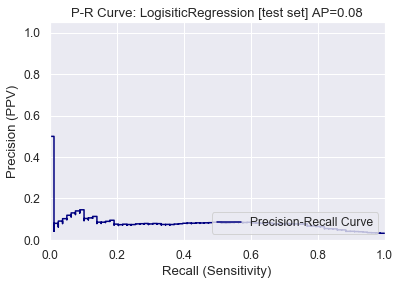

In [24]:
# plot a Precision-Recall curve
# compute avg. precision score:
y_score_lr = lr.fit(X_train_resampled, y_train_resampled).predict_proba(X_val.values)[:,1]
avg_precision = skm.average_precision_score(y_val, y_score_lr)
print('Average P-R score of Logistic Regression: {0:0.2f}'.format(avg_precision))

# Plot a P-R curve:
precision, recall, _ =skm.precision_recall_curve(y_val, y_score_lr)
plt.step(recall, precision, color='navy', where='post', label='Precision-Recall Curve')
plt.title('P-R Curve: LogisiticRegression [test set] AP={0:0.2f}'.format(avg_precision))
plt.xlabel('Recall (Sensitivity)')
plt.ylabel('Precision (PPV)')
plt.ylim([0, 1.05])
plt.xlim([0, 1.0])
plt.legend(loc='lower right')
plt.show()

### Summary of Precision-Recall Curve ###
Overall, the Logistic Regression showed weighted average precision of 0.08. In other words, about 8% of time, the model is good at making stroke predictions from total # of actual stroke cases.

## Part 4 - DEPLOY ##

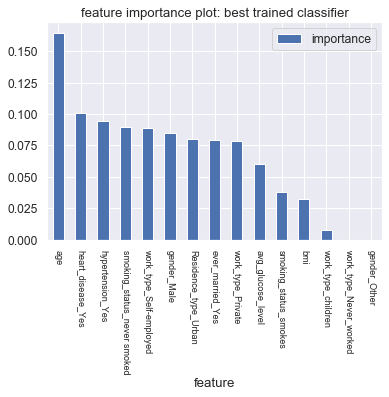

In [25]:
# --- 20. Automate the model pipeline --- #
# make predictions based on a test set
df_test_selected = test_df.copy()
df_pred_probs = lr.predict_proba(df_test_selected)

# make predictions dataframe:
results = pd.DataFrame({'id':df_test_id,
                        'stroke':df_pred_probs[:,1]})
results.to_csv('prob_results_lr.csv', index=False, index_label=None)

# --- 21. Deploy the solution --- #
#store feature importances
if hasattr(model, 'feature_importances_'):
    importances = model.feature_importances_
else:
# linear models don't have feature_importances_
    importances = [0]*len(X_train.columns)

# Create a feature importance dataframe and sort by importance:    
feature_importances = pd.DataFrame({'feature':X_train.columns,
                                        'importance':importances})
feature_importances.sort_values(by='importance', inplace=True, ascending=False)

# Set index to 'feature'
feature_importances.set_index('feature', inplace=True, drop=True)

# Create a bar plot:    
feature_importances[0:15].plot.bar(align='center')
plt.xticks(rotation=270, fontsize=9)
plt.title('feature importance plot: best trained classifier')
plt.show()
    
#Save model results as .csv file:
model_results(model, mean_roc_auc[model], results, feature_importances)

### Model Summary: Feature Importance ###
A figure showed the feature importance on the best trained model from order of the highest to lowest feature importance ranks.

Top 10 important features were age followed by heart_disease_yes, hypertension_yes, never smoked, etc..